In [1]:
from signal_utils import *

In [2]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class RFProcessingConfig:
    N: int
    F: float
    delay_kernel: List[float]
    i_delta: float
    q_delta: float
    osr: int
    AdB: float
    Fmax: float
    cpp_path: str
    quant_type: str
    LUT: List[List[int]]
    dtype: str
    plotShow: bool

In [23]:
def plotFigure(x, x_range, title="", AdB=None, freq_factor=None, y_range=None):
    freqs, xfftdB, angle = fftdB(x, win=True)
    if freq_factor:
        freqs *= freq_factor
    xmin = x_range[0]
    xmax = x_range[1]
    plt.title(title)
    plt.plot(freqs, xfftdB)
    if AdB:
        plt.plot([xmin, xmax], [-AdB, -AdB], '--r')
    plt.xlim([xmin, xmax])
    if y_range:
        plt.ylim([y_range[0], y_range[1]])
    plt.xlabel("f/fs")
    plt.ylabel("|X|dB")
    plt.grid()
    plt.show();   

def process(x, config):
    N = config.N
    n = np.arange(N)
    F = config.F
    i_delta = config.i_delta #1/8 * 1/32*1/8
    q_delta = config.q_delta #-1/8 * 1/32*1/8
    
    AdB = config.AdB
    perc = 0.15
    Fmax = config.Fmax
    
    # xi = 1.0 * np.cos(2*np.pi*F*n)
    # xq = 1.0 * np.sin(2*np.pi*F*n)
    # x = xi + 1j*xq

    if config.dtype == "true-shift":
        # True Fractional Shift
        xi_shift = 1.0 * np.cos(2*np.pi*F*(n-i_delta))
        xq_shift = 1.0 * np.sin(2*np.pi*F*(n-q_delta))
    elif config.dtype == "taylor-shift":
        xi = x[0]
        xq = x[1]
        xi_shift = frac_delay_1st(xi, i_delta, config.delay_kernel)
        xq_shift = frac_delay_1st(xq, q_delta, config.delay_kernel)
    elif config.dtype == "no-shift":
        xi_shift = x[0]
        xq_shift = x[1]
    
    # Interpolation
    OSR = config.osr
    deltaPass = 10**(-AdB/20)
    deltaStop = deltaPass
    delta_interpolation = [deltaPass, deltaStop]
    F_interpolation = [Fmax, 1-Fmax]
    xi_osr = np.real(interpolate(xi_shift, OSR, F_interpolation, delta_interpolation, show=False, prt=False))
    xq_osr = np.real(interpolate(xq_shift, OSR, F_interpolation, delta_interpolation, show=False, prt=False))
    
    # Delta-Sigma modulation
    # factor = 4/np.max(np.abs(xi_osr + 1j*xq_osr))
    factor = 4*OSR
    xi_osr *= factor
    xq_osr *= factor
    quant_type = config.quant_type
    cpp_path = config.cpp_path
    xi_in_path = "./data/serial/xi_in.txt"
    xq_in_path = "./data/serial/xq_in.txt"
    xi_out_path = "./data/serial/xi_out.txt"
    xq_out_path = "./data/serial/xq_out.txt"
    iir_path = "../data/input/deltaSigma_iirs.txt"
    np.savetxt(xi_in_path, xi_osr, fmt="%.18e")
    np.savetxt(xq_in_path, xq_osr, fmt="%.18e")
    subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, iir_path, quant_type])  # Call the C++ program with input and output file paths as arguments
    xi_deltaSigma = np.loadtxt(xi_out_path)
    xq_deltaSigma = np.loadtxt(xq_out_path)
    
    # Serialization
    LUT = config.LUT
    xi_1b = convert_1b_optimized(xi_deltaSigma, LUT, quant_type)
    xq_1b = convert_1b_optimized(xq_deltaSigma, LUT, quant_type)
    
    # RFIQ
    x_rfiq = rfiq(xi_1b, xq_1b)
    

    if config.plotShow:
        x_delay_true = xi_shift + 1j*xq_shift
        x_osr = xi_osr + 1j*xq_osr
        x_deltaSigma = xi_deltaSigma + 1j*xq_deltaSigma
        x_1b = xi_1b + 1j*xq_1b
        
        xrange = np.array([-.5, .5])
        # plotFigure(x, xrange)
        plotFigure(x_delay_true, xrange, title = "Delayed Signal")
        plotFigure(x_osr, xrange, AdB=AdB, title = f"Interpolated Signal, OSR = {OSR}")
        plotFigure(x_deltaSigma, xrange, title = "Delta-Sigma Modulation")
        plotFigure(x_1b, xrange/len(LUT[0]), title = "Serialized Signal, LUT")
        plotFigure(x_rfiq, xrange/len(LUT[0])+1, freq_factor=4, y_range=[-150,5], title = "Reconstructed Signal on fs")
        # plotFigure(x_rfiq, xrange/len(LUT[0])/8+1, freq_factor=4, y_range=[-150,5])

    return x_rfiq

def find_SNR(x, f_range, bandwidth=0.005):
    freqs, spectrum_dB, _ = fftdB(x)
    freqs *= 4  # or whatever scaling is correct for your freq axis

    f_low, f_high = f_range

    # 1. Get frequency range of interest
    idx_band = np.where((freqs >= f_low) & (freqs <= f_high))[0]
    freqs_band = freqs[idx_band]
    spectrum_band = spectrum_dB[idx_band]

    # 2. Find peak index (signal)
    idx_peak_local = np.argmax(spectrum_band)
    peak_freq = freqs_band[idx_peak_local]
    signal_level = spectrum_band[idx_peak_local]

    # 3. Exclude bins around the peak
    idx_exclude_local = np.where(
        (freqs_band >= peak_freq - bandwidth) &
        (freqs_band <= peak_freq + bandwidth)
    )[0]

    # 4. Keep only noise bins
    idx_noise_local = np.setdiff1d(np.arange(len(freqs_band)), idx_exclude_local)

    if len(idx_noise_local) == 0:
        raise ValueError("No noise bins left after excluding signal.")

    noise_floor = np.max(spectrum_band[idx_noise_local])

    return signal_level - noise_floor

In [24]:
k3 = np.array([0.5, 0.0, -0.5])
k5 = np.array([-1, 8, 0, -8, +1]) / 12.0
k7 = np.array([1, -9, +45, 0, -45, +9, -1]) / 60.0
k9 = np.array([-1, 12, -39, +56, 0, -56, +39, -12, +1]) / 280.0

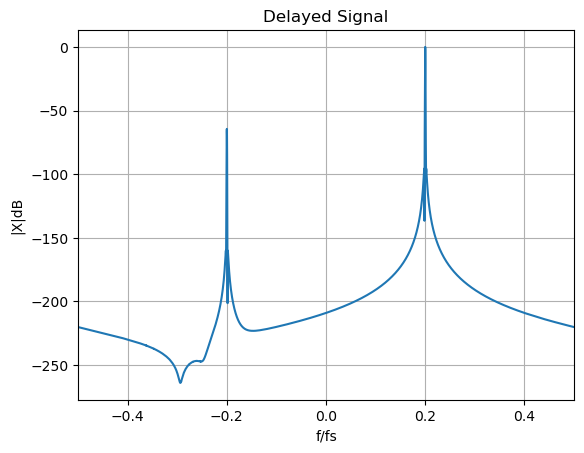

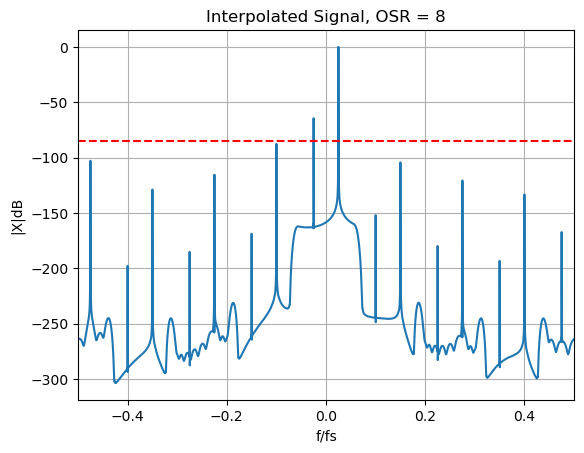

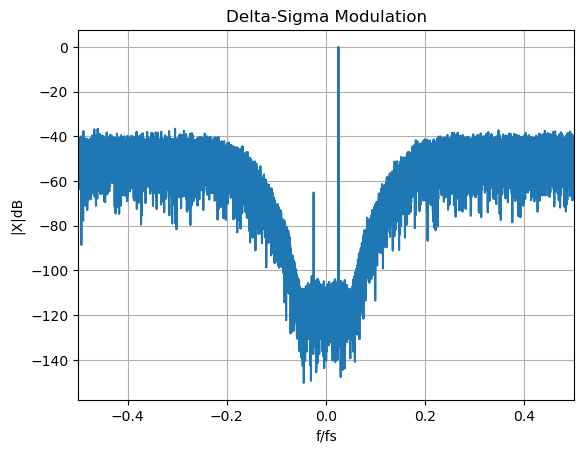

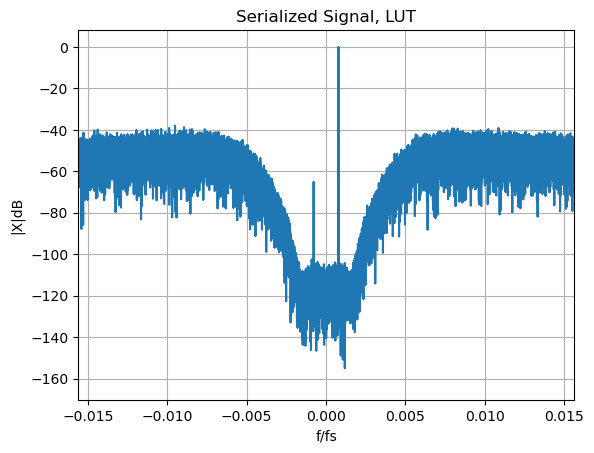

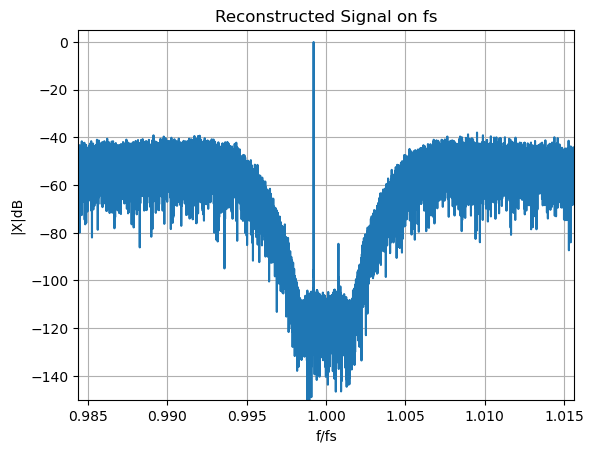

SNR = 84.6173920348107


In [37]:
cpp_path = "../build/delta-sigma" #"../build/delta-sigma"
quant_type = 'mid-tread'
LUT = LUT3

N = 2**12
n = np.arange(N)
perc = 0.15
Fmax = 0.5 * (1 - perc)

i_delta = -1/8 * 1/8 * 1/len(LUT[0])
q_delta = 1/8 * 1/8 * 1/len(LUT[0])

OSR = 8

F = 0.2
xi = 1.0*np.cos(2*np.pi*F*n)
xq = 1.0*np.sin(2*np.pi*F*n)
x = [xi, xq]

config = RFProcessingConfig(
    N = N,
    F = F,
    delay_kernel = k7,
    i_delta = i_delta,
    q_delta = q_delta,
    osr = 8,
    AdB = 85,
    Fmax = Fmax,
    cpp_path = cpp_path,
    quant_type = quant_type,
    LUT = LUT,
    dtype = "taylor-shift",
    plotShow = True,
)

x_rfiq = process(x, config)

factor = 0.5 / len(LUT[0]) / 8
bandwidth = 0.1 / len(LUT[0]) / 8
f_range = [1 - factor, 1 + factor]
snr = find_SNR(x_rfiq, f_range=f_range, bandwidth=bandwidth)
print(f"SNR = {snr}")